# Recommender Systems - Practical Work
## Jean-François BENHAIM
### 31/07/2020

# Data Loading

In [1]:
from surprise import Dataset, Reader
import pandas as pd
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise import KNsicNBa, NMF, sic
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_sel.validationdation import validateoss_va
import numpylidate

In [2]:
df = pd.read_csv('data/cleaned_movie_ratings.csv', index_col=0)
input_file = data/'cleaned_ratings_no_index.csv'
df.iloc[:, :4].to_csv(input_file, index=False)

In [3]:
reader = Reader(line_format='user item rating timestamp', skip_lines=1, rating_scale=(0,5), sep=',')

data = Dataset.load_from_file(input_file, reader)


In [4]:
data.raw_ratings[:5]

[('1', '31', 2.5, '1260759144'),
 ('1', '1029', 3.0, '1260759179'),
 ('1', '1061', 3.0, '1260759182'),
 ('1', '1129', 2.0, '1260759185'),
 ('1', '1172', 4.0, '1260759205')]

# Utils


In [5]:
def predict_score_CF(data,  user_based=True, similarity='cosine'):
    sim_options = {'name': similarity,
               'user_based': user_based
                }
    algo = KNNBasic(sim_options=sim_options, k=20)
    return cross_validate(algo, data, cv=5)

def get_average_kpi(result):
    avg_result = {}
    for alg, kpis in result.items():
        avg_result[alg] = {}
        for k, v in kpis.items():
            avg_result[alg][k] = np.mean(v)
    return avg_result 


# Models training and KPI computation

## Collaborative Filter models
Let's use KNNBasic as the benchmark, before training all the 4 different type of models, let's estimate the best k parameter for one of the models.  
We will use the same k for all the Collaborative Filter models.

In [10]:
from surprise.model_selection import GridSearchCV

param_grid = {'k': [2, 5, 10, 20, 40, 50,  75, 100]}

clf = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'])
clf.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [11]:
print('mean RMSE', clf.cv_results['mean_test_rmse'])
print('mean MAE', clf.cv_results['mean_test_mae'])
print('k', clf.cv_results['param_k'])
index_best = np.argmin(clf.cv_results['mean_test_rmse'])
print(f"\nBest k: {clf.cv_results['param_k'][index_best]}")

mean RMSE [1.07300212 0.98052344 0.95622132 0.95141971 0.95482637 0.95658562
 0.9596785  0.9615661 ]
mean MAE [0.8176943  0.75080859 0.73161205 0.72842413 0.73283362 0.73467879
 0.73799707 0.73998057]
k [2, 5, 10, 20, 40, 50, 75, 100]

Best k: 20


In [12]:
%%time

all_result = {}
for similiarity in ['cosine', 'pearson']:
    for user_based in [False, True]:
        if user_based:
            all_result[similiarity + '_user_based'] = predict_score_CF(data, user_based=user_based, similarity=similiarity)
        else:
            all_result[similiarity + '_content_based'] = predict_score_CF(data, user_based=user_based, similarity=similiarity)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing

In [13]:
all_result['cosine_content_based']

{'test_rmse': array([0.99544266, 0.99872612, 0.99641176, 0.99443511, 0.99411138]),
 'test_mae': array([0.77802417, 0.77597763, 0.77850424, 0.77702142, 0.77472675]),
 'fit_time': (9.240450620651245,
  9.860440015792847,
  8.329000473022461,
  8.307851076126099,
  9.85254716873169),
 'test_time': (3.281904697418213,
  3.800438404083252,
  3.5093934535980225,
  4.93913197517395,
  4.531396865844727)}

## SVD
Let's start with a gridsearch to estimate the best parameters for 3 parameters (n_factors, n_epochs and lr_all).  
We will leave the others as default.
We will do it in 2 steps to avoid too long computation.


In [14]:
param_grid = {'n_factors': [25, 50, 100, 200]}
clf = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'])
clf.fit(data)

In [15]:
print('mean RMSE', clf.cv_results['mean_test_rmse'])
print('mean MAE', clf.cv_results['mean_test_mae'])
print('k', clf.cv_results['param_n_factors'])
index_best = np.argmin(clf.cv_results['mean_test_rmse'])
print(f"\nBest n_factors: {clf.cv_results['param_n_factors'][index_best]}")

mean RMSE [0.88610552 0.88839105 0.89141075 0.89721262]
mean MAE [0.68064008 0.6824398  0.68546853 0.68929082]
k [25, 50, 100, 200]

Best n_factors: 25


As we can see above, the number of factor doesn't seem to have an important impact on the metrics.  
But lower number gives slightly better result so we will use that.


In [16]:
%%time
param_grid = {'n_factors': [25], 'n_epochs': [10, 20, 50], 'lr_all': [0.005, 0.001, 0.01, 0.0005]}
clf = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'])
clf.fit(data)

Wall time: 3min 48s


In [17]:
print('mean RMSE', clf.cv_results['mean_test_rmse'])
print('mean MAE', clf.cv_results['mean_test_mae'])
print('n_epochs', clf.cv_results['param_n_epochs'])
print('learning_rate', clf.cv_results['param_lr_all'])
index_best = np.argmin(clf.cv_results['mean_test_rmse'])
print(f"\nBest params:\nn_epochs {clf.cv_results['param_n_epochs'][index_best]} - lr_all {clf.cv_results['param_lr_all'][index_best]}")

mean RMSE [0.89238776 0.92216636 0.88705521 0.94222438 0.88636186 0.90671844
 0.89874908 0.92231471 0.91139656 0.89203995 0.95367064 0.90215816]
mean MAE [0.68687089 0.71572997 0.6818896  0.73801772 0.6815792  0.69978315
 0.68936566 0.71597845 0.69716085 0.68630117 0.72979823 0.69530045]
n_epochs [10, 10, 10, 10, 20, 20, 20, 20, 50, 50, 50, 50]
learning_rate [0.005, 0.001, 0.01, 0.0005, 0.005, 0.001, 0.01, 0.0005, 0.005, 0.001, 0.01, 0.0005]

Best params:
n_epochs 20 - lr_all 0.005


In [18]:
svd_model = SVD(n_factors=25, n_epochs = 20, lr_all=0.005)
all_result['SVD'] = cross_validate(svd_model, data, cv=5)

## NMF
Let's start with a gridsearch to estimate the best parameters for the first 2 parameters.  
We will leave the others as default.

In [19]:
%%time
param_grid = {'n_factors': [5, 20, 15, 25], 'n_epochs': [10, 20, 50]}
clf = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'])
clf.fit(data)

Wall time: 3min 2s


In [20]:
print('mean RMSE', clf.cv_results['mean_test_rmse'])
print('mean MAE', clf.cv_results['mean_test_mae'])
print('n_epochs', clf.cv_results['param_n_epochs'])
print('n_factors', clf.cv_results['param_n_factors'])
index_best = np.argmin(clf.cv_results['mean_test_rmse'])
print(f"\nBest params:\nn_epochs {clf.cv_results['param_n_epochs'][index_best]} - n_factors {clf.cv_results['param_n_factors'][index_best]}")

mean RMSE [1.86385403 1.51358199 1.04791766 1.19890347 1.05480819 0.9439949
 0.95363113 0.94173972 0.94682674 1.42371919 1.20230188 0.94927606]
mean MAE [1.68222204 1.33342554 0.854094   0.9177231  0.79279714 0.71748246
 0.72264454 0.71770189 0.72727496 1.12379046 0.92031974 0.71731491]
n_epochs [10, 20, 50, 10, 20, 50, 10, 20, 50, 10, 20, 50]
n_factors [5, 5, 5, 20, 20, 20, 15, 15, 15, 25, 25, 25]

Best params:
n_epochs 20 - n_factors 15


In [21]:
nmf_model = NMF(n_factors=15, n_epochs = 20)
all_result['NMF'] = cross_validate(nmf_model, data, cv=5)

# Model Comparison

In [22]:
avg_result = get_average_kpi(all_result)
print(avg_result['SVD'])

{'test_rmse': 0.8863217135336627, 'test_mae': 0.6811618816541226, 'fit_time': 1.8762522220611573, 'test_time': 0.1443418502807617}


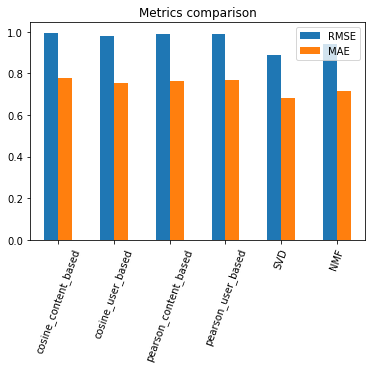

In [23]:
import matplotlib.pyplot as plt
kpi_df = pd.DataFrame(avg_result).T
kpi_df = kpi_df.rename(columns={'test_rmse': 'RMSE', 'test_mae': 'MAE','test_time': 'prediction_time'})

kpi_df[['RMSE', 'MAE']].plot(kind='bar')
plt.title('Metrics comparison')
plt.xticks(rotation=70)
plt.show()

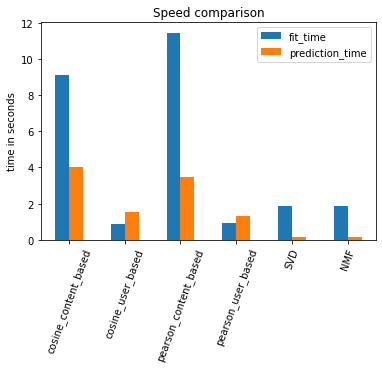

In [24]:
kpi_df[['fit_time', 'prediction_time']].plot(kind='bar')
plt.title('Speed comparison')
plt.ylabel('time in seconds')
plt.xticks(rotation=70)
plt.show()

# Conclusion

From the KPIs, we can see that the error metrics of all the models are quite similar with the exception of the SVD model that has a slightly lower RMSE and MAE.  
So on error metrics only, the SVD seems like the best choice for this dataset.

From the speed point of view, we notice that in the collaborative filtering, the content based are clearly the longest, both to train and to predict.  
This is understandable as there are much more movies than users.  
While user based algorithms are the fastest to train, they are still much longer than SVD and NMF for predictions.  
This was also expected since the collaborative Filtering models need to check the distance with all the user in the database to make their predictions.  
NMF and SVD have very similar fit and predict time, with NMF slightly faster on predictions.

Overall, based on error and speed metrics, it seems the SVD is the best model for our dataset.  
It will allow for the lowest error whil being quite fast for predictions.  
Only potential issue may be the fit time when it needs to be retrained with a new batch of data.